In [22]:
import sys
sys.path.append('..')
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from hamp_pred.external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.output_analysis.visual import reg_plot
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt

## Prepare data

In [44]:
DATA_DIR = '../../data/input'
data = f'{DATA_DIR}/af_clean_model_train_val.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)

## Train and validate

In [6]:
def get_rmse(val, mod):
    seqs = list(val.train_seq)
    tr=[]
    for n,r in val.iterrows():
        tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
    res = mod.predict(seqs)
    pr = []
    for n,r in res.iterrows():
        pr.append(np.mean(r['N_pred'])/2)
    return np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

In [7]:
def train(conf, version):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    trained = mod.train(data)
    return mod, trained

def get_mod(conf=None, version=None):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    return mod
    

In [8]:
def opt_conf(val=None, tune=False):
    results = {}
    if val is None:
        val = f'{DATA_DIR}/af_clean_model_test.p'
        val = pd.read_pickle(val)
    kernels = [(3, 5, 7)]
    layers = [1,3]
    lstm = [1, 2]
    dense = [1, 3]
    for kern in kernels:
        for l in layers:
            for ls in lstm:
                for d in dense:
                    model_config = {
                        'activation': 'tanh',
                        'norm': True,
                        'n_layers': l,
                        'kernel_sizes': kern,
                        'lstm': ls,
                        'dense': d,
                        'reshape_out': False,
                        'epochs': 100
                    }
                    version = '_'.join([str(x) for x in [kern, l, ls, d]])
                    if tune:
                        mod, trained = train(model_config, version)
                    else:
                        mod = get_mod(model_config, version)
                    results[version] = get_rmse(val, mod)
    return results
        

## Tune hiperparameters

In [75]:
res = opt_conf(data[data['class'] == 'val'], tune=False)  

## Best Config

In [9]:
model_conf = model_config = {
    'activation': 'tanh',
    'norm': True,
    'n_layers': 1,
    'kernel_sizes': (3, 5, 7),
    'lstm': 2,
    'dense': 3,
    'reshape_out': False,
    'epochs': 100
}
mod = get_mod()

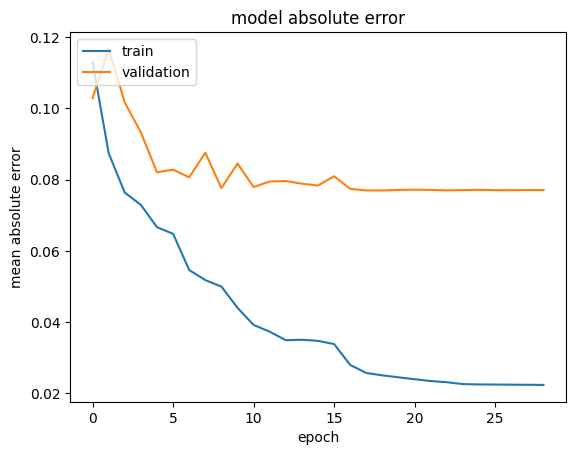

In [5]:
plt.plot(trained.history.history['mae'])
plt.plot(trained.history.history['val_mae'])
plt.title('model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

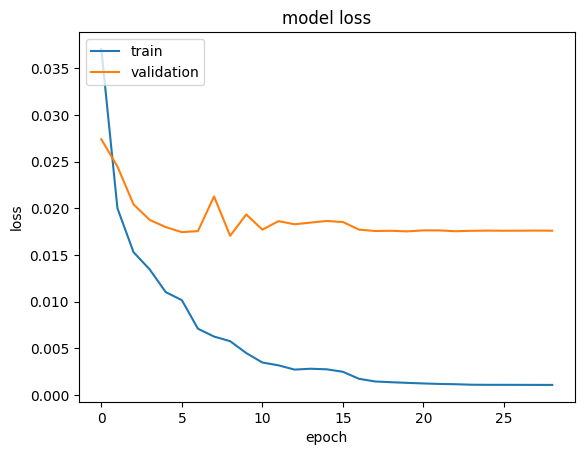

In [6]:
plt.plot(trained.history.history['loss'])
plt.plot(trained.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Alpha fold test set results 

In [52]:
af_test_results = mod.predict(val, is_test=True)

1/1 [==============================] - 2s 2s/step


<AxesSubplot: title={'center': 'Prediction for af2 test set'}, xlabel='Predicted', ylabel='PDB Structure'>

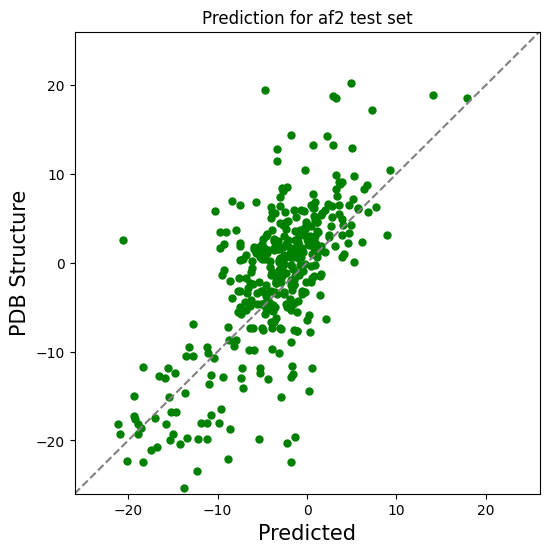

In [53]:
reg_plot(af_test_results['true_mean_rot'], af_test_results['pred_mean_rot'], title='Prediction for af2 test set', ylabel='PDB Structure')

## Validation RMSE per position

In [57]:
pdb_test_results['mse_pos'] ** 0.5

8.739028156875937

## RMSE on AF2 test set

In [58]:
pdb_test_results['mse_seq'] ** 0.5

5.3664815197351485

## Test on PDB

In [59]:
test_data = pd.read_pickle(f'{DATA_DIR}/pdb_measure.p')

In [60]:
test_data = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
test_data = test_data[~test_data.mutant]
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
test_data['n_seq'] = test_data['n_seq'].apply(lambda x: x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x: x[1:-1])
test_data['train_seq'] = test_data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(test_data)

11

In [61]:
pdb_test_results = mod.predict(test_data, is_test=True)

1/1 [==============================] - 1s 1s/step


In [62]:
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'HAMPpred model #1')

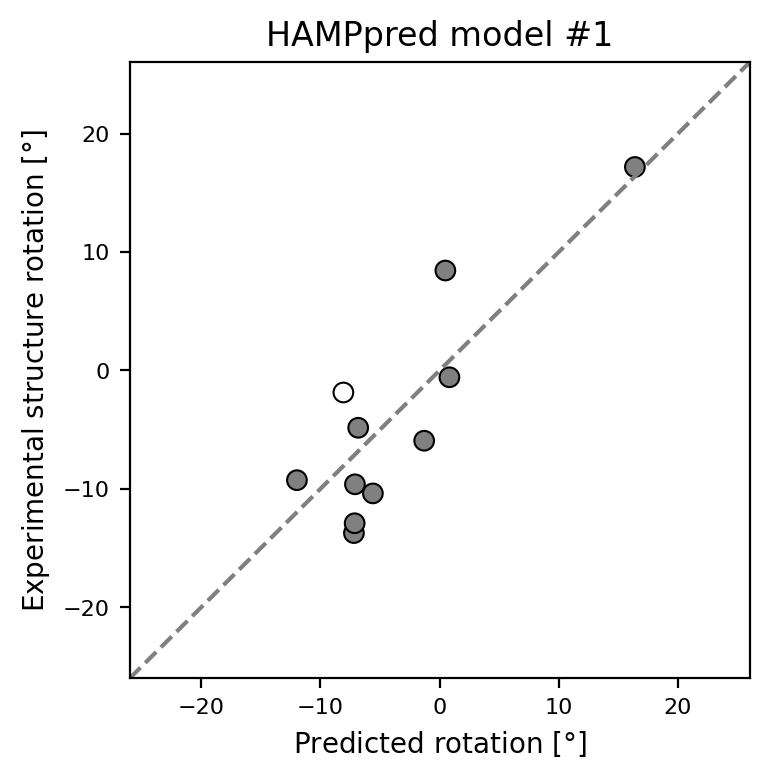

In [63]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in test_data.index]

ax.scatter(pr, tr, color=colors, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred model #1", size=title_font_size)

## RMSE on PDB test set

In [64]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

4.696145507529099

## Validation MSE per position

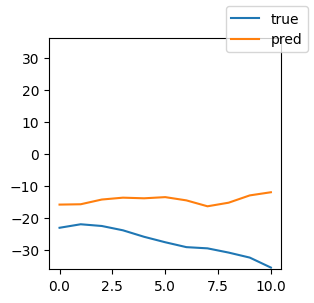

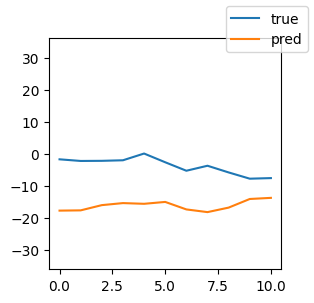

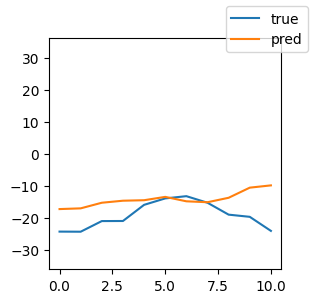

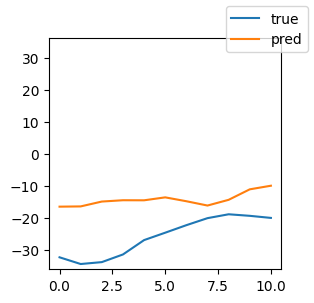

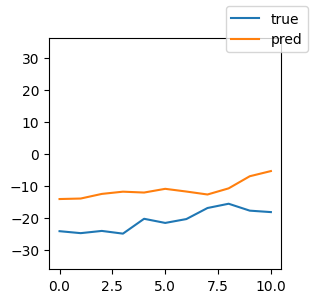

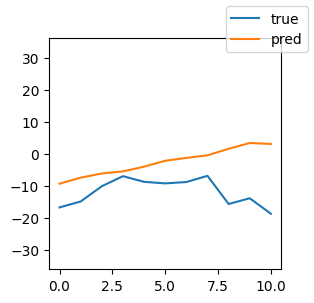

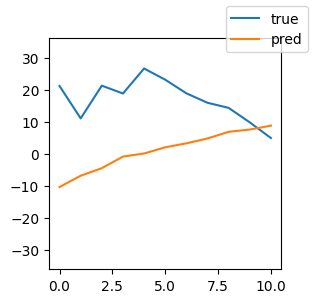

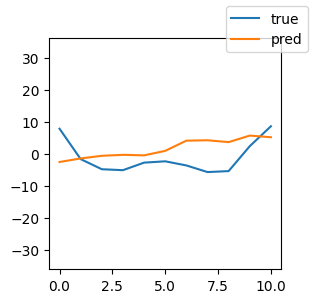

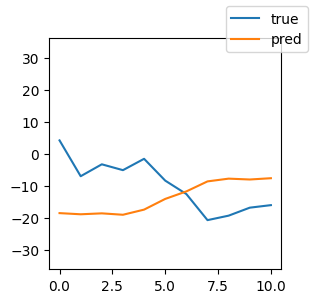

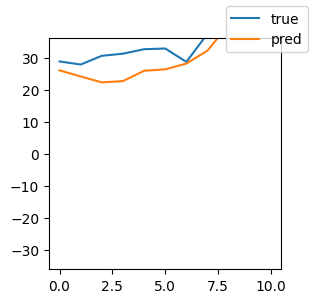

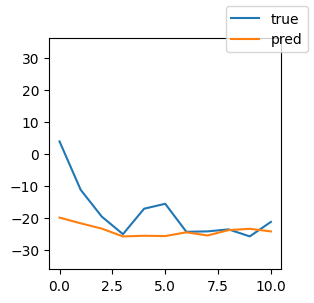

In [19]:
for i in range(len(test_data)):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
    r = test_data.iloc[i]
    tr = (r['rot'][0::2] + r['rot'][1::2]) / 2
    pred = res.iloc[i]['N_pred']
    ax.plot(tr, label='true')
    ax.plot(pred, label='pred')
    ax.set_ylim(-36, 36)
    fig.legend(); pass